In [1]:
import numpy as np
import pandas as pd
import random
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Я использую готовый датасет по URL:
# https://www.kaggle.com/datasets/ruchi798/bookcrossing-dataset?select=Book+reviews

# 1. Считываю данные.
ratings = pd.read_csv('archive/Book reviews/BX-Book-Ratings.csv', sep=';', encoding='latin-1')
books   = pd.read_csv('archive/Book reviews/BX_Books.csv', sep=';', encoding='latin-1')
users   = pd.read_csv('archive/Book reviews/BX-Users.csv', sep=';', encoding='latin-1')

# 2. Очищаю от "нулевых" рейтингов (означают просто просмотр, "0" != плохо).
ratings = ratings[ratings['Book-Rating'] > 0]

# 3. Привожу названия колонок к единообразному виду.
ratings.columns = ratings.columns.str.strip().str.replace('-', '_')
books.columns = books.columns.str.strip().str.replace('-', '_')
users.columns = users.columns.str.strip().str.replace('-', '_')

# 4. Присоединяю названия книг и URL обложек к рейтингу.
ratings = ratings.merge(
    books[['ISBN', 'Book_Title', 'Image_URL_M']],
    on='ISBN',
    how='left'
)

# 5. Отбираю пользователей, которые поставили хотя бы 1 оценку.
active_users = ratings['User_ID'].unique()

# 6. Если пользователей больше 50, выбираю топ-50 по числу оценок.
if len(active_users) > 50:
    user_counts = ratings['User_ID'].value_counts()
    selected_users = user_counts.head(50).index.tolist()
else:
    selected_users = list(active_users)
    
# 7. Отфильтровываю оценки выбранных пользователей (массив строк таблицы).
filtered = ratings[(ratings['User_ID'].isin(selected_users))]

# 8. Выбираю топ-100 популярных книг среди этих пользователей (по числу оценок) (массив).
top_books = filtered['Book_Title'].value_counts().head(50).index.tolist()

# 9. Фильтрую датасет по выбранным книгам.
filtered = filtered[filtered['Book_Title'].isin(top_books)]

# 10. Получаю список уникальных книг и пользователей после фильтрации (массивы).
books_list = filtered['Book_Title'].unique().tolist()
users_raw = filtered['User_ID'].unique().tolist()

# 11. Переименовываю пользователей для удобства.
user_map = {uid: f'User {i+1}' for i, uid in enumerate(users_raw)}
users = list(user_map.values())

# 12. Создаю матрицу предпочтений: user -> {book: rating}.
preferences = {}
for uid in users_raw:
    user_data = filtered[filtered['User_ID'] == uid]
    preferences[user_map[uid]] = dict(zip(user_data['Book_Title'], user_data['Book_Rating']))

# 13. Формирую словарь обложек.
book_covers = dict(zip(filtered['Book_Title'], filtered['Image_URL_M']))

print(f"Пользователей: {len(users)}")
print(f"Книг: {len(books_list)}")
print("Пример preferences:")
for user, prefs in list(preferences.items())[:3]:
    print(f"{user}: {list(prefs.items())[:3]}")

Пользователей: 44
Книг: 50
Пример preferences:
User 1: [('Misery', 7)]
User 2: [('To Kill a Mockingbird', 8), ('One for the Money (Stephanie Plum Novels (Paperback))', 8), ('The Secret Garden', 9)]
User 3: [('One for the Money (Stephanie Plum Novels (Paperback))', 9), ('The Secret Garden', 8), ('Fried Green Tomatoes at the Whistle Stop Cafe', 7)]


In [3]:
# Инициализация Q-таблицы: Q[user][book_index] = значение.
Q = defaultdict(lambda: np.zeros(len(books_list))) 

In [4]:
# Определение функции награды 
def get_reward(user, book): 
    return preferences[user].get(book, 0) # 0 - если не оценивал

In [5]:
# Параметры обучения.
alpha = 0.1 # Скорость обучения
gamma = 0.9 # Коэффициент дисконтирования
epsilon = 0.1 # Вероятность случайного выбора действия (epsilon-жадная стратегия)
num_episodes = 1000 # Количество эпизодов обучения
for episode in range(num_episodes):
    user = random.choice(users)
    available_books = books_list.copy()
    while available_books:
        if random.uniform(0, 1) < epsilon:
            # Случайный выбор книги.
            book = random.choice(available_books)
        else:
            # Выбор книги с наибольшим Q-значением.
            available_book_indices = [books_list.index(b) for b in available_books]
            book_idx = np.argmax(Q[user][available_book_indices])
            book = available_books[book_idx]
        
        reward = get_reward(user, book)
        best_next_action = np.max(Q[user][available_book_indices])
        # Обновление Q-таблицы.
        book_idx = books_list.index(book)
        Q[user][book_idx] = Q[user][book_idx] + alpha * (reward + gamma *
        best_next_action - Q[user][book_idx])
        # Удаляем выбранную книгу из доступных.
        available_books.remove(book)

In [6]:
# Тестирование системы рекомендаций.
def recommend_book(user):
    book_idx = np.argmax(Q[user])
    return books_list[book_idx]
# Тестирование рекомендаций.
recommendations = {}
for user in users:
    recommended_book = recommend_book(user)
    recommendations[user] = recommended_book
    print(f"Recommended book for {user}: {recommended_book}")

Recommended book for User 1: Misery
Recommended book for User 2: A Wrinkle in Time
Recommended book for User 3: Misery
Recommended book for User 4: Silence of the Lambs
Recommended book for User 5: The Joy Luck Club
Recommended book for User 6: It
Recommended book for User 7: One for the Money (Stephanie Plum Novels (Paperback))
Recommended book for User 8: Misery
Recommended book for User 9: Silence of the Lambs
Recommended book for User 10: Bridget Jones's Diary
Recommended book for User 11: When the Wind Blows
Recommended book for User 12: Harry Potter and the Prisoner of Azkaban (Book 3)
Recommended book for User 13: A Wrinkle in Time
Recommended book for User 14: Jurassic Park
Recommended book for User 15: The Bonesetter's Daughter
Recommended book for User 16: The Secret Garden
Recommended book for User 17: To Kill a Mockingbird
Recommended book for User 18: Watchers
Recommended book for User 19: Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback))
Recommended book fo

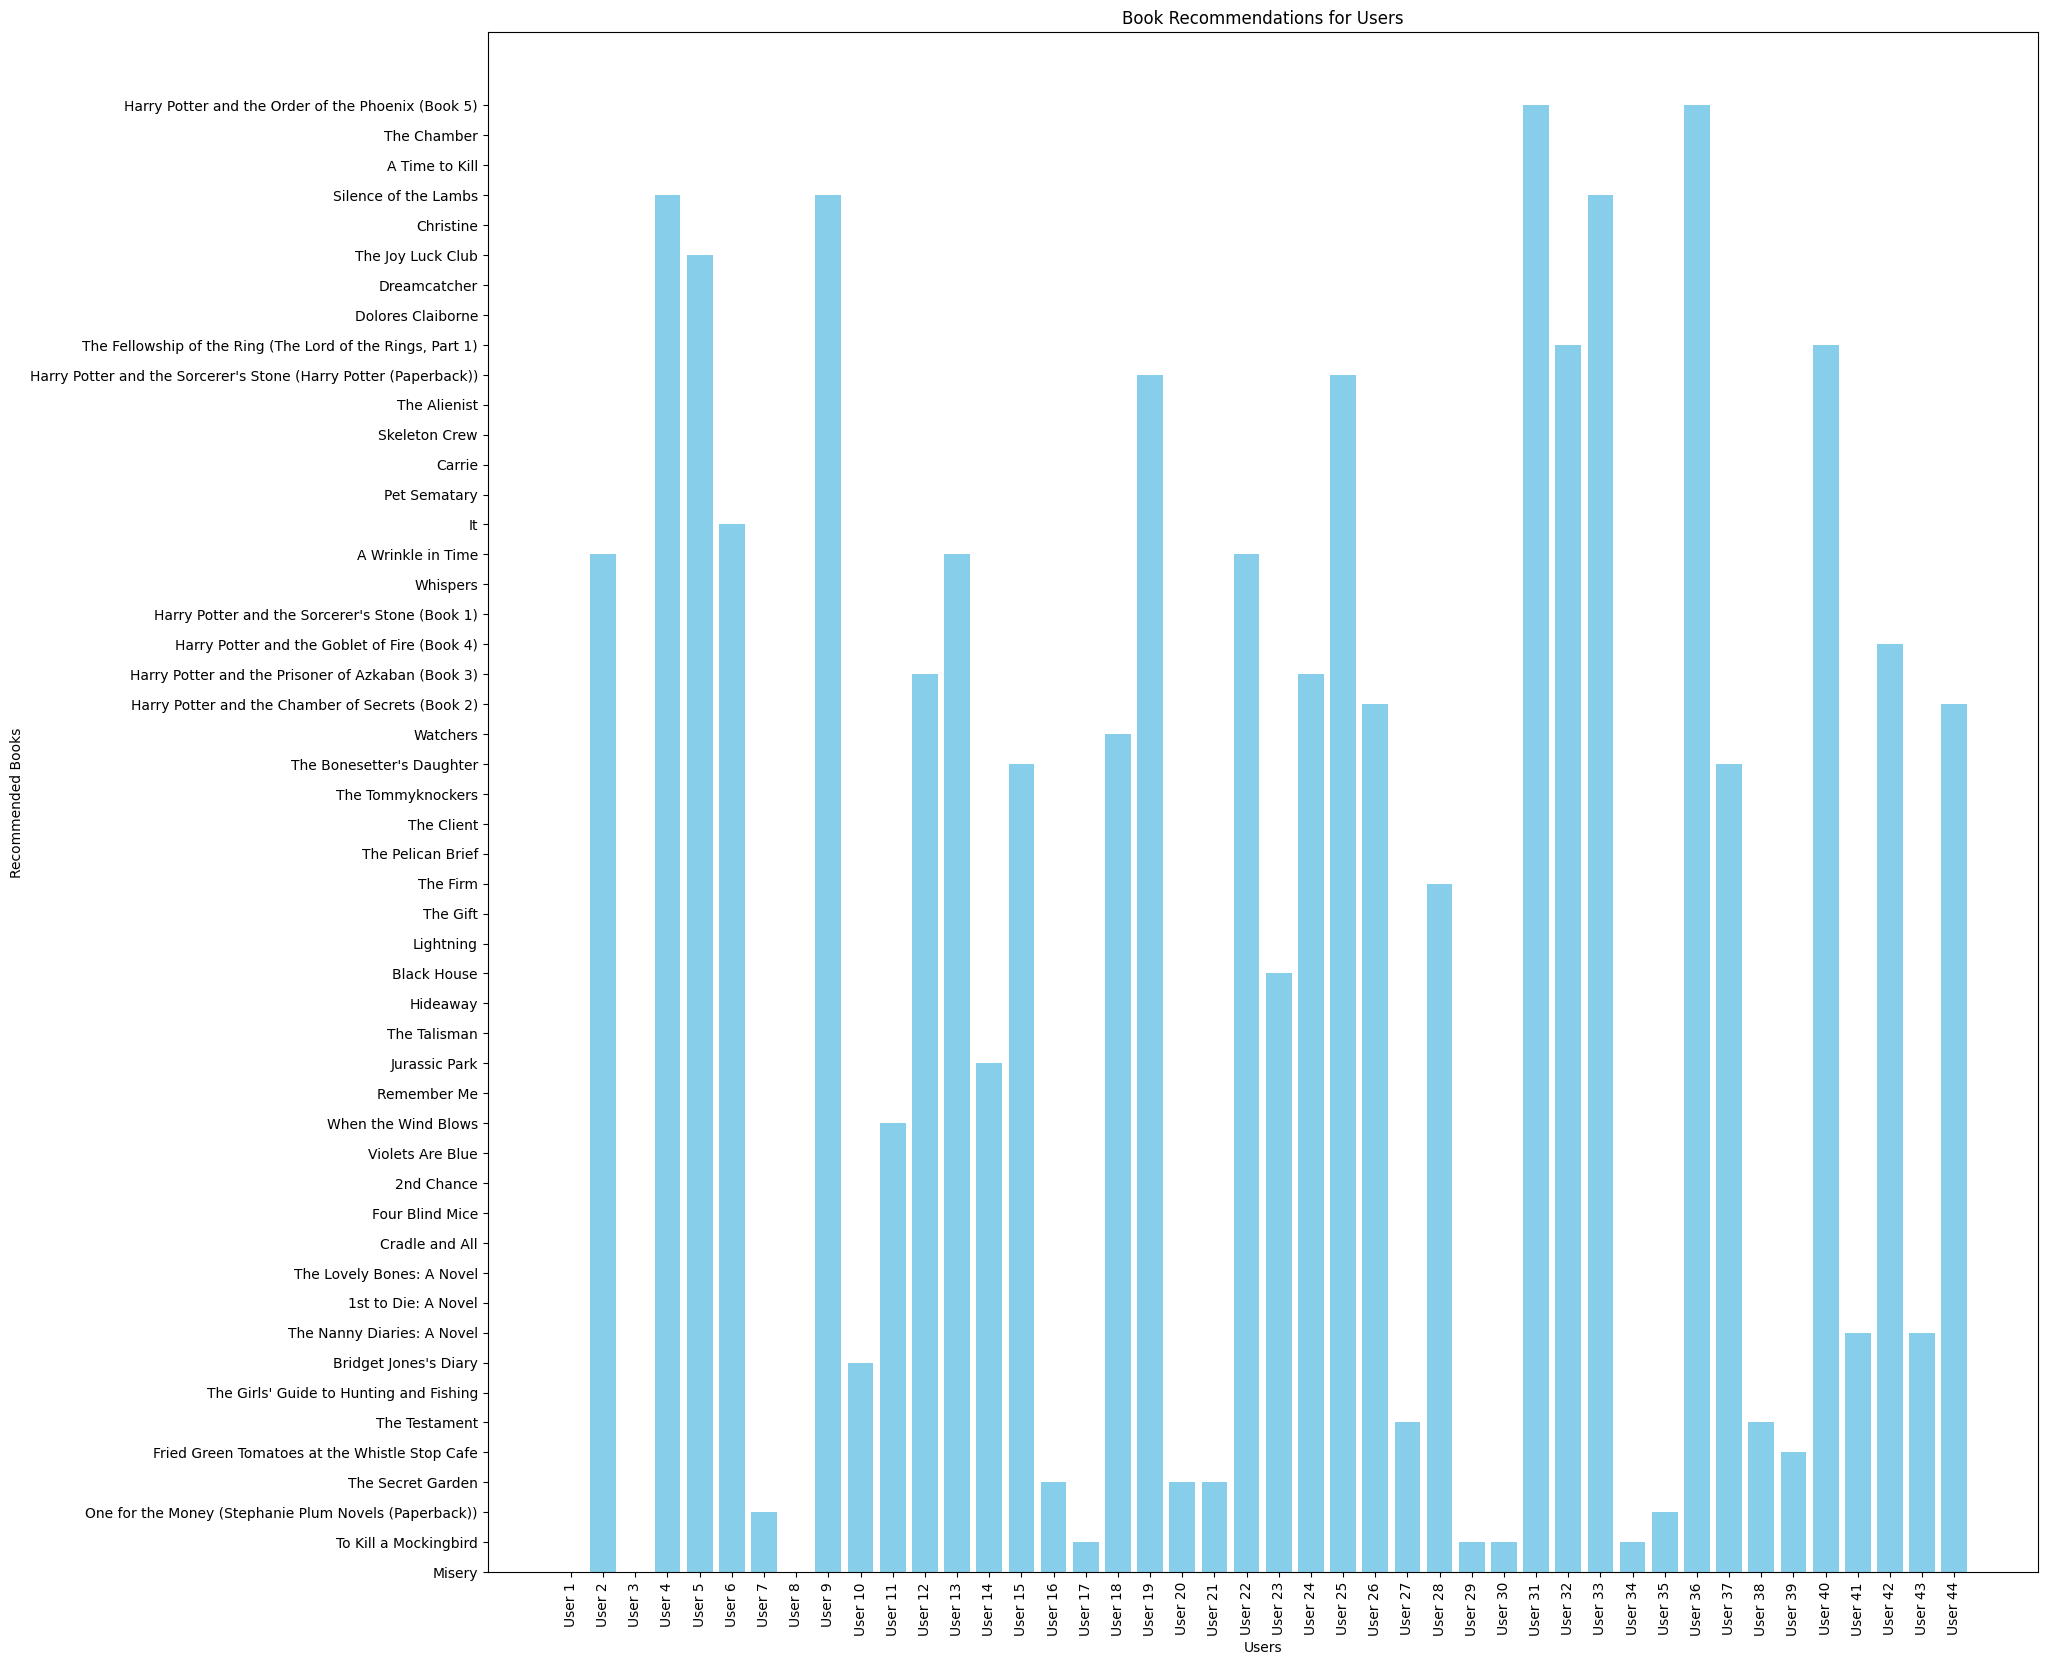

In [7]:
# Визуализация рекомендаций
plt.figure(figsize=(20, 20))
plt.bar(recommendations.keys(), [books_list.index(book) for book in
recommendations.values()], color='skyblue')
plt.xticks(rotation=90)
plt.yticks(range(len(books_list)), books_list)
plt.xlabel('Users')
plt.ylabel('Recommended Books')
plt.title('Book Recommendations for Users')
plt.show()

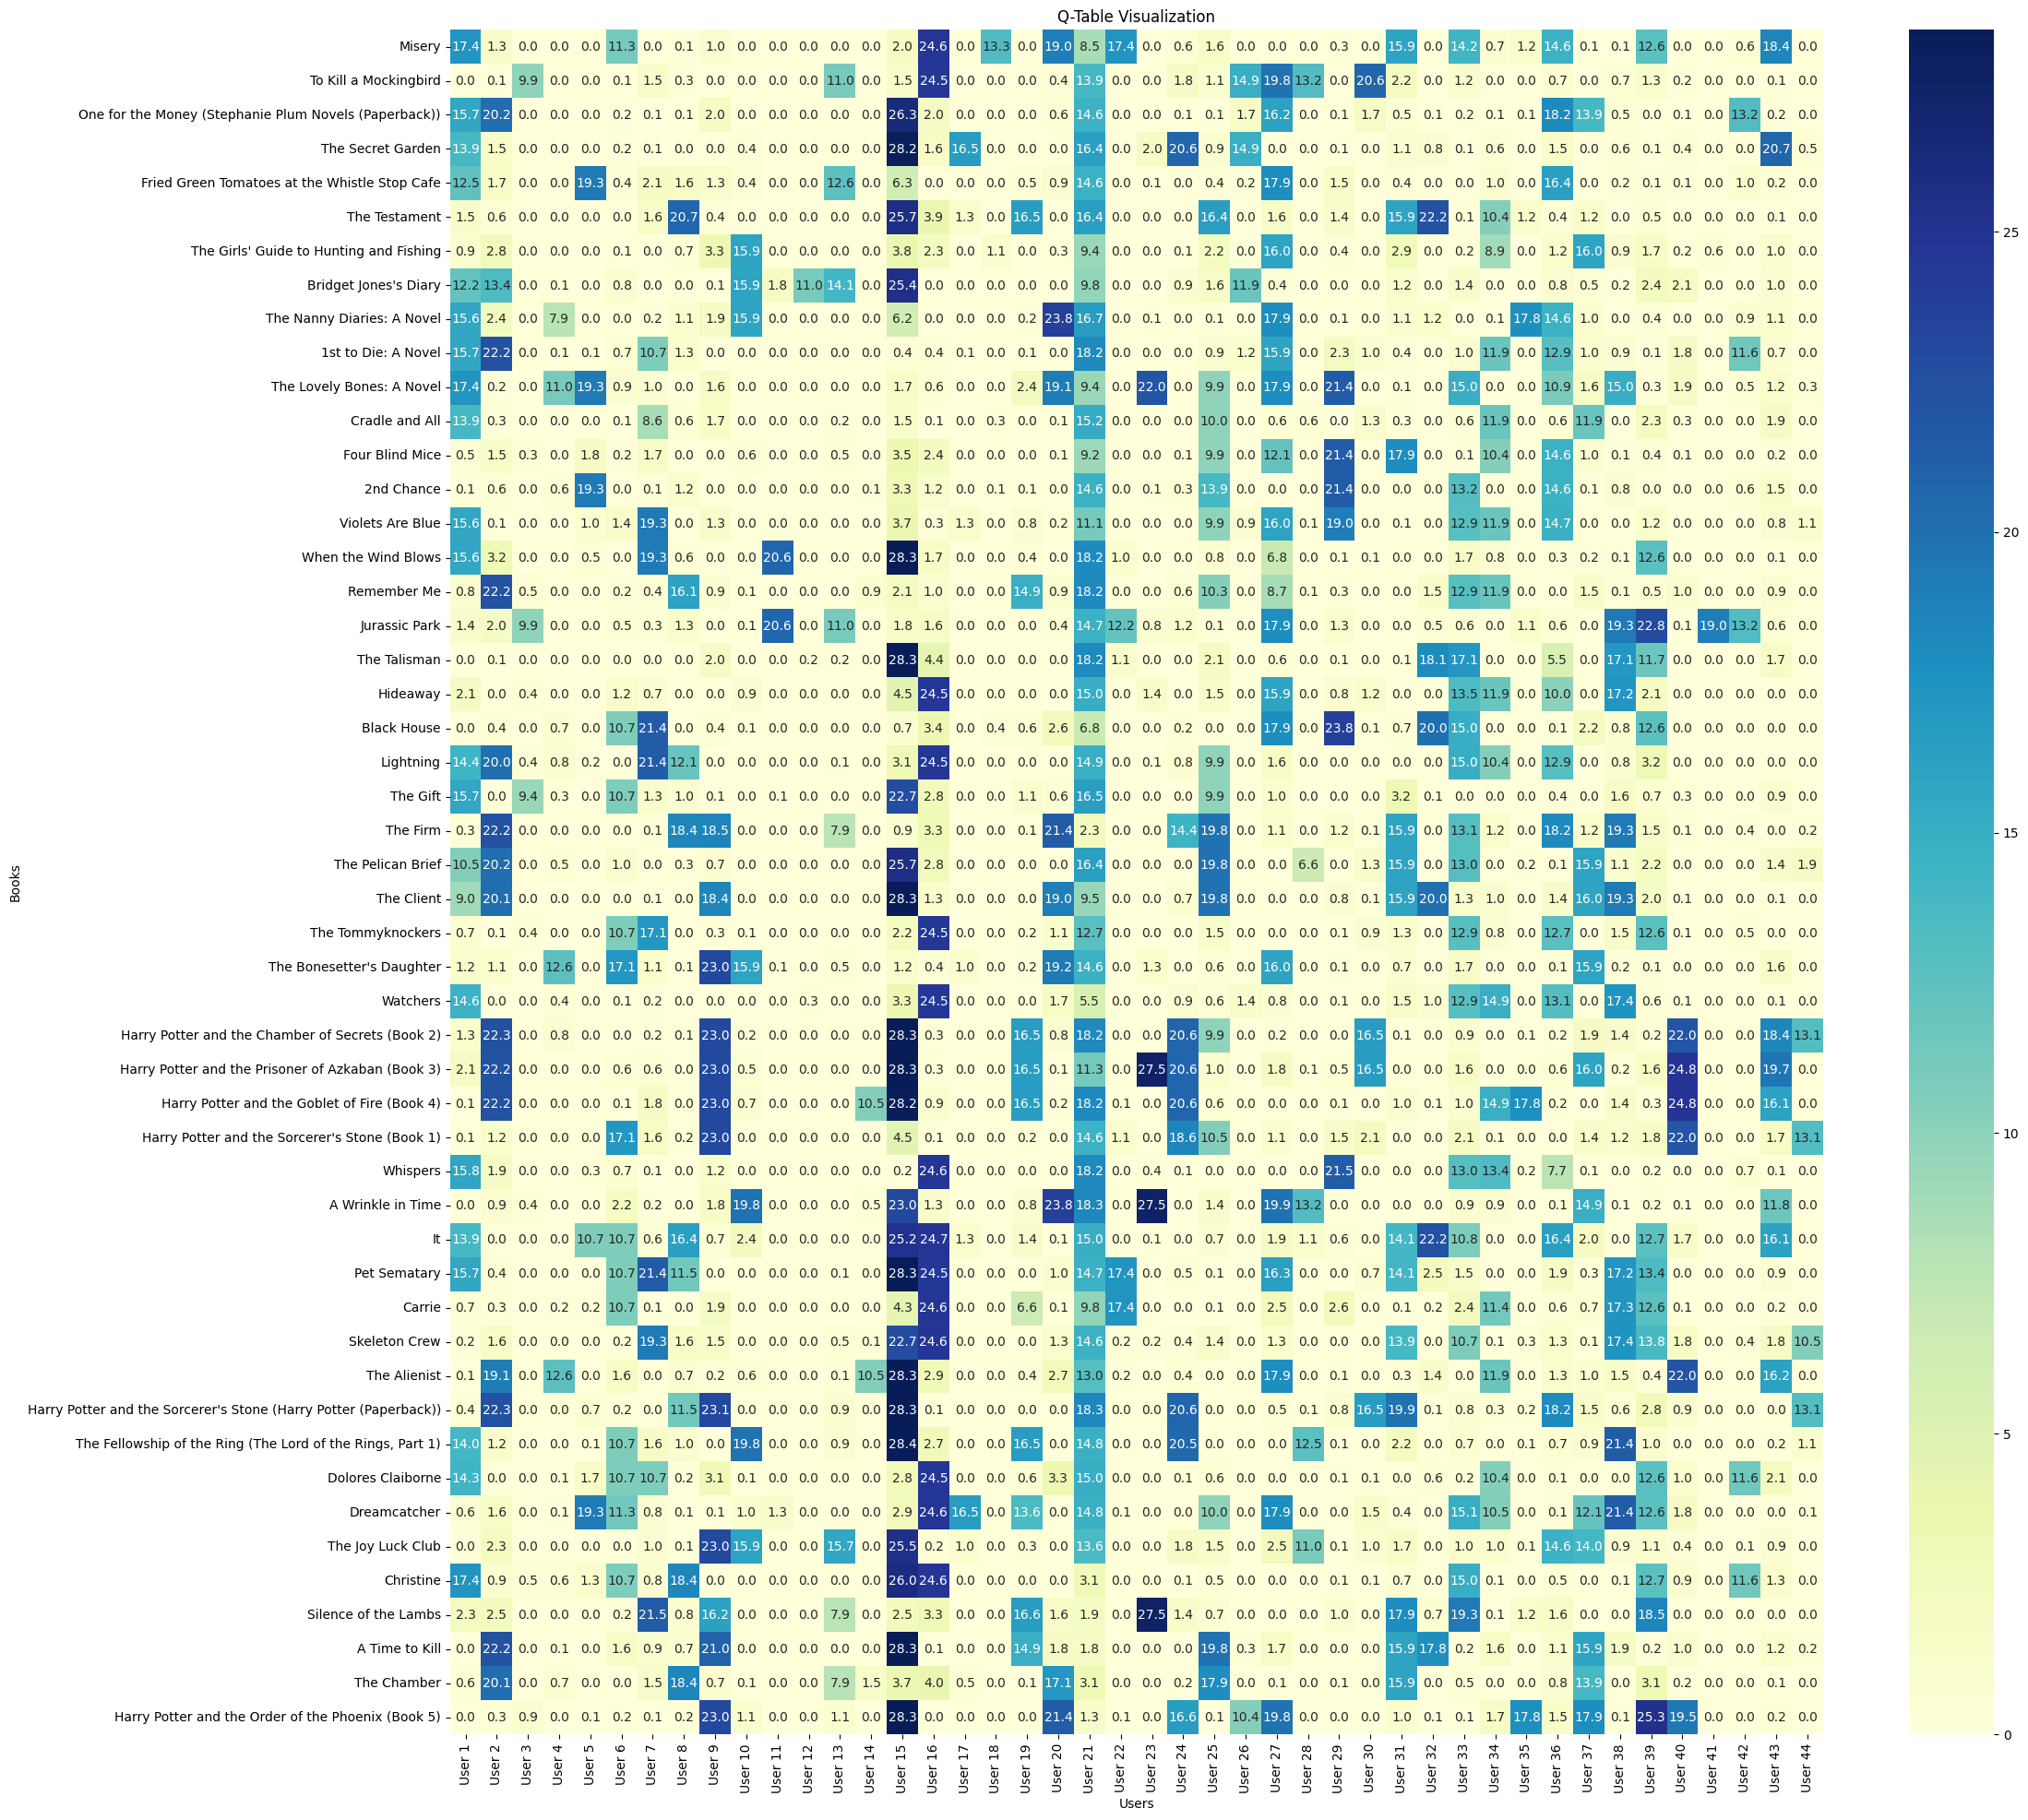

In [10]:
# Визуализация Q-таблицы.
q_table_df = pd.DataFrame(Q, index=books_list)
q_table_df.columns = users
plt.figure(figsize=(24, 24))
sns.heatmap(q_table_df, annot=True, cmap='YlGnBu', fmt='.1f')
plt.title('Q-Table Visualization')
plt.xlabel('Users')
plt.ylabel('Books')
plt.show()

In [11]:
from IPython.display import Image, display

# Датасет содержит URL-ссылки на обложки книг, интересно...
for title, url in book_covers.items():
    print(title)
    display(Image(url=url))

Misery


To Kill a Mockingbird


One for the Money (Stephanie Plum Novels (Paperback))


The Secret Garden


Fried Green Tomatoes at the Whistle Stop Cafe


The Testament


The Girls' Guide to Hunting and Fishing


Bridget Jones's Diary


The Nanny Diaries: A Novel


1st to Die: A Novel


The Lovely Bones: A Novel


Cradle and All


Four Blind Mice


2nd Chance


Violets Are Blue


When the Wind Blows


Remember Me


Jurassic Park


The Talisman


Hideaway


Black House


Lightning


The Gift


The Firm


The Pelican Brief


The Client


The Tommyknockers


The Bonesetter's Daughter


Watchers


Harry Potter and the Chamber of Secrets (Book 2)


Harry Potter and the Prisoner of Azkaban (Book 3)


Harry Potter and the Goblet of Fire (Book 4)


Harry Potter and the Sorcerer's Stone (Book 1)


Whispers


A Wrinkle in Time


It


Pet Sematary


Carrie


Skeleton Crew


The Alienist


Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback))


The Fellowship of the Ring (The Lord of the Rings, Part 1)


Dolores Claiborne


Dreamcatcher


The Joy Luck Club


Christine


Silence of the Lambs


A Time to Kill


The Chamber


Harry Potter and the Order of the Phoenix (Book 5)
